Previous imports make sure package interpolation is installed.

In [ ]:
!pip install interpolation

Imports...

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from interpolation import interp
from scipy.optimize import minimize_scalar, bisect

## Reviewing the Model

You might like to [review the details](https://python.quantecon.org/cake_eating_problem.html) before we start.

Recall in particular that the Bellman equation is


<a id='equation-bellman-cen'></a>
$$
v(x) = \max_{0\leq c \leq x} \{u(c) + \beta v(x-c)\}
\quad \text{for all } x \geq 0. \tag{44.1}
$$

where $ u $ is the CRRA utility function.

The analytical solutions for the value function and optimal policy were found
to be as follows.

In [4]:
def c_star(x, beta, gamma):

    return (1 - beta ** (1/gamma)) * x


def v_star(x, beta, gamma):

    return (1 - beta**(1 / gamma))**(-gamma) * (x**(1-gamma) / (1-gamma))

Our first aim is to obtain these analytical solutions numerically.

## Value Function Iteration

The first approach we will take is **value function iteration**.

This is a form of **successive approximation**, and was discussed in our [lecture on job search](https://python.quantecon.org/mccall_model.html).

The basic idea is:

1. Take an arbitary intial guess of $ v $.  
1. Obtain an update $ w $ defined by  
  $$
  w(x) = \max_{0\leq c \leq x} \{u(c) + \beta v(x-c)\}
  $$
1. Stop if $ w $ is approximately equal to $ v $, otherwise set
  $ v=w $ and go back to step 2.  


Let’s write this a bit more mathematically.

### The Bellman Operator

We introduce the **Bellman operator** $ T $ that takes a function v as an
argument and returns a new function $ Tv $ defined by

$$
Tv(x) = \max_{0 \leq c \leq x} \{u(c) + \beta v(x - c)\}
$$

From $ v $ we get $ Tv $, and applying $ T $ to this yields
$ T^2 v := T (Tv) $ and so on.

This is called **iterating with the Bellman operator** from initial guess
$ v $.

As we discuss in more detail in later lectures, one can use Banach’s
contraction mapping theorem to prove that the sequence of functions $ T^n
v $ converges to the solution to the Bellman equation.

### Fitted Value Function Iteration

Both consumption $ c $ and the state variable $ x $ are continuous. This causes complications when it comes to numerical work. For example, we need to store each function $ T^n v $ in order to
compute the next iterate $ T^{n+1} v $.

But this means we have to store $ T^n v(x) $ at infinitely many $ x $, which is, in general, impossible. To circumvent this issue we will use fitted value function iteration, as
discussed previously in [one of the lectures](https://python.quantecon.org/mccall_fitted_vfi.html) on job search.

The process looks like this:

1. Begin with an array of values $ \{ v_0, \ldots, v_I \} $  representing
  the values of some initial function $ v $ on the grid points $ \{ x_0, \ldots, x_I \} $.  
1. Build a function $ \hat v $ on the state space $ \mathbb R_+ $ by
  linear interpolation, based on these data points.  
1. Obtain and record the value $ T \hat v(x_i) $ on each grid point
  $ x_i $ by repeatedly solving the maximization problem in the Bellman
  equation.  
1. Unless some stopping condition is satisfied, set
  $ \{ v_0, \ldots, v_I \} = \{ T \hat v(x_0), \ldots, T \hat v(x_I) \} $ and go to step 2.  


In step 2 we’ll use continuous piecewise linear interpolation.

### Implementation

The `maximize` function below is a small helper function that converts a
SciPy minimization routine into a maximization routine.

In [5]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

We’ll store the parameters $ \beta $ and $ \gamma $ in a
class called `CakeEating`.

The same class will also provide a method called `state_action_value` that
returns the value of a consumption choice given a particular state and guess
of $ v $.

In [7]:
class CakeEating:

    def __init__(self,
                 beta=0.96,        # discount factor
                 gamma=1.5,        # degree of relative risk aversion
                 x_grid_min=1e-3,  # exclude zero for numerical stability
                 x_grid_max=5,   # size of cake
                 x_grid_size=100):

        self.beta, self.gamma = beta, gamma

        # Set up grid
        self.x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)

    # Utility function
    def u(self, c):

        gamma = self.gamma

        if gamma == 1:
            return np.log(c)
        else:
            return (c ** (1 - gamma)) / (1 - gamma)

    # first derivative of utility function
    def u_prime(self, c):

        return c ** (-self.gamma)

    def state_action_value(self, c, x, v_array):
        """
        Right hand side of the Bellman equation given x and c.
        """

        u, beta = self.u, self.beta
        v = lambda x: interp(self.x_grid, v_array, x)

        return u(c) + beta * v(x - c)

Define the Bellman operation:

In [8]:
def T(v, ce):
    """
    The Bellman operator.  Updates the guess of the value function.

    * ce is an instance of CakeEating
    * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)

    for i, x in enumerate(ce.x_grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(ce.state_action_value, 1e-10, x, (x, v))[1]

    return v_new

After defining the Bellman operator, we are ready to solve the model.

Let’s start by creating a `CakeEating` instance using the default parameterization.

In [9]:
ce = CakeEating()

Now let’s see the iteration of the value function in action.

We start from guess $ v $ given by $ v(x) = u(x) $ for every
$ x $ grid point.

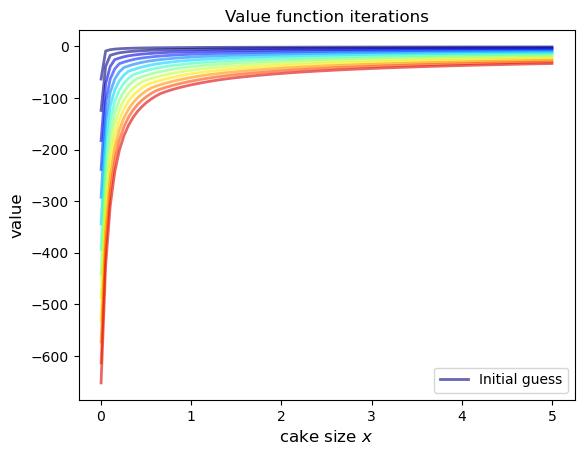

In [10]:
x_grid = ce.x_grid
v = ce.u(x_grid)       # Initial guess
n = 12                 # Number of iterations

fig, ax = plt.subplots()

ax.plot(x_grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial guess')

for i in range(n):
    v = T(v, ce)  # Apply the Bellman operator
    ax.plot(x_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.legend()
ax.set_ylabel('value', fontsize=12)
ax.set_xlabel('cake size $x$', fontsize=12)
ax.set_title('Value function iterations')

plt.show()

To do this more systematically, we introduce a wrapper function called
`compute_value_function` that iterates until some convergence conditions are
satisfied.

In [11]:
def compute_value_function(ce,
                           tol=1e-4,
                           max_iter=1000,
                           verbose=True,
                           print_skip=25):

    # Set up loop
    v = np.zeros(len(ce.x_grid)) # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v, ce)

        error = np.max(np.abs(v - v_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        v = v_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return v_new

Now let’s call it, noting that it takes a little while to run.


In [12]:
v = compute_value_function(ce)

Error at iteration 25 is 23.8003755134813.
Error at iteration 50 is 8.577577195046615.
Error at iteration 75 is 3.091330659691039.
Error at iteration 100 is 1.1141054204751981.
Error at iteration 125 is 0.4015199357729671.
Error at iteration 150 is 0.14470646660561215.
Error at iteration 175 is 0.052151735472762084.
Error at iteration 200 is 0.018795314242879613.
Error at iteration 225 is 0.006773769545361574.
Error at iteration 250 is 0.002441244304918655.
Error at iteration 275 is 0.0008798164324161917.
Error at iteration 300 is 0.00031708295364296646.
Error at iteration 325 is 0.00011427565550548024.

Converged in 329 iterations.


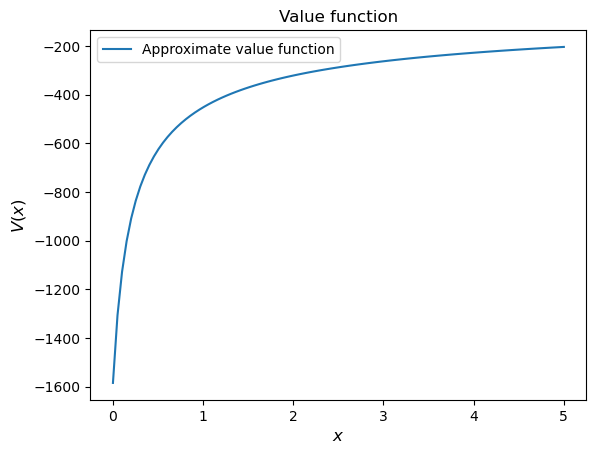

In [13]:
fig, ax = plt.subplots()

ax.plot(x_grid, v, label='Approximate value function')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.set_title('Value function')
ax.legend()
plt.show()

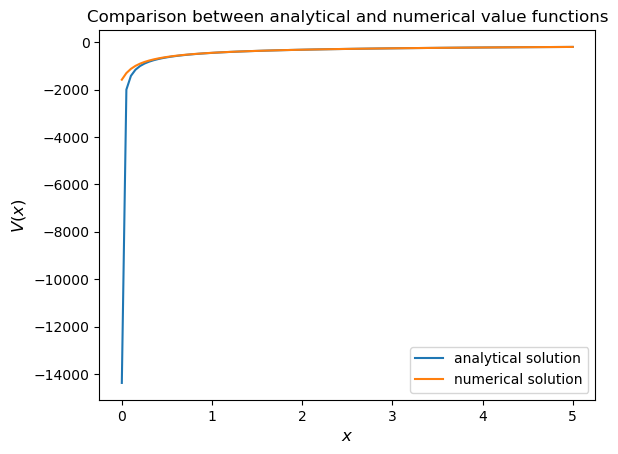

In [14]:
v_analytical = v_star(ce.x_grid, ce.beta, ce.gamma)
fig, ax = plt.subplots()

ax.plot(x_grid, v_analytical, label='analytical solution')
ax.plot(x_grid, v, label='numerical solution')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.legend()
ax.set_title('Comparison between analytical and numerical value functions')
plt.show()

Lets now check for policy functions!

### Policy Function

Let’s see how this plays out in terms of computing the optimal policy.

In the [first lecture on cake eating](https://python.quantecon.org/cake_eating_problem.html), the optimal
consumption policy was shown to be

$$
\sigma^*(x) = \left(1-\beta^{1/\gamma} \right) x
$$

Let’s see if our numerical results lead to something similar.

Our numerical strategy will be to compute

$$
\sigma(x) = \arg \max_{0 \leq c \leq x} \{u(c) + \beta v(x - c)\}
$$

on a grid of $ x $ points and then interpolate.

For $ v $ we will use the approximation of the value function we obtained
above.

Here’s the function:

In [15]:
def sigma(ce, v):
    """
    The optimal policy function. Given the value function,
    it finds optimal consumption in each state.

    * ce is an instance of CakeEating
    * v is a value function array

    """
    c = np.empty_like(v)

    for i in range(len(ce.x_grid)):
        x = ce.x_grid[i]
        # Maximize RHS of Bellman equation at state x
        c[i] = maximize(ce.state_action_value, 1e-10, x, (x, v))[0]

    return c

In [16]:
c = sigma(ce, v)

<a id='pol-an'></a>
Let’s plot this next to the true analytical solution

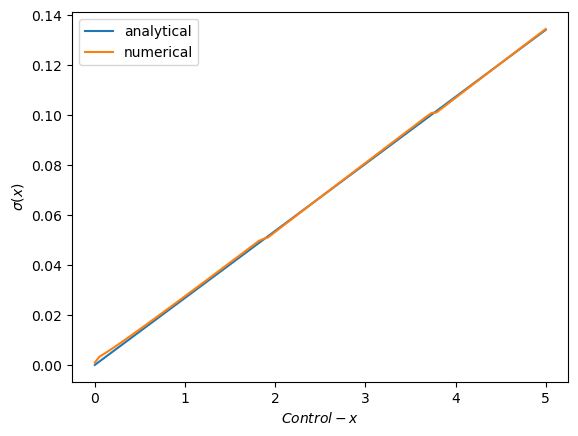

In [19]:
c_analytical = c_star(ce.x_grid, ce.beta, ce.gamma)

fig, ax = plt.subplots()

ax.plot(ce.x_grid, c_analytical, label='analytical')
ax.plot(ce.x_grid, c, label='numerical')
ax.set_ylabel(r'$\sigma(x)$')
ax.set_xlabel('$State - x$')
ax.legend()

plt.show()